In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

np.random.seed(42)
%matplotlib inline

In [2]:
data = fetch_olivetti_faces()
x = data.data
y = data.target

In [3]:
print(x.shape)
print(y.shape)

(400, 4096)
(400,)


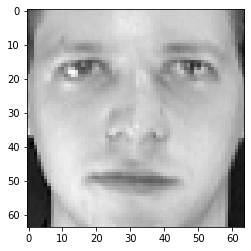

In [4]:
plt.imshow(x[0].reshape(64, 64), cmap='gray')

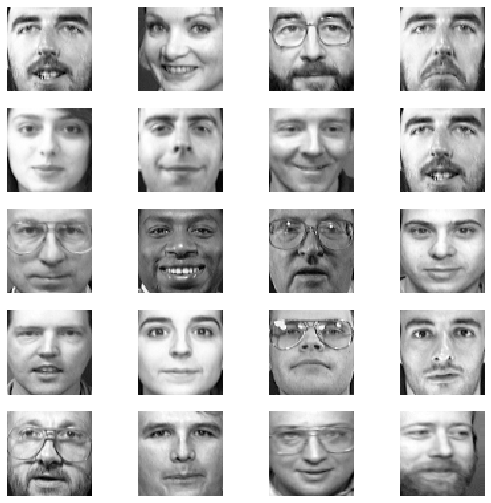

In [5]:
# Looking on a random set of images
fig = plt.figure(figsize=(9, 9))
cols = 4
rows = 5
for ind in range(1, cols*rows+1):
    img = x[np.random.randint(x.shape[0])].reshape(64, 64)
    fig.add_subplot(rows, cols, ind)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
plt.show()

In [6]:
x.shape

(400, 4096)

In [10]:
# Splitting into train and test set and having equal proportions
from sklearn.model_selection import StratifiedShuffleSplit

split_test = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_valid_ind, test_ind in split_test.split(x, y):
    x_train_valid, x_test = x[train_valid_ind], x[test_ind]
    y_train_valid, y_test = y[train_valid_ind], y[test_ind]

split_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, valid_ind in split_valid.split(x_train_valid, y_train_valid):
    x_train, x_valid = x_train_valid[train_ind], x_train_valid[valid_ind]
    y_train, y_valid = y_train_valid[train_ind], y_train_valid[valid_ind]

### PCA Reduction

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
x_train_pca = pca.fit_transform(x_train)
x_valid_pca = pca.transform(x_valid)

In [24]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(x_train_pca)

In [25]:
# Generating random samples for further processing
x_gen, y_gen = gm.sample(20)

In [26]:
# Converting samples to full size for displaying
print(x_gen.shape)
x_gen = pca.inverse_transform(x_gen)
print(x_gen.shape)

(20, 203)
(20, 4096)


### Visualizing Sampled Images by GMM

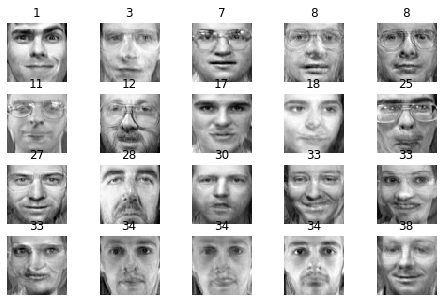

In [28]:
def plot_faces(faces, label, n_rows = 4, n_cols = 5): 
    plt.figure(figsize=(8, 5))
    for index, (face, label) in enumerate(zip(faces, label)):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(face.reshape(64, 64), cmap='gray')
        plt.axis("off")
        plt.title(label)
    plt.show()
    
plot_faces(x_gen, y_gen)

### Modifying Images and detecting anomalies

In [85]:
from scipy import ndimage

# rotated, flipped and darkened the images
# flipping and darkening has been used from solution as turned out to be easier
x_transformed = []
for face in x_train[:20]:
    transform = ndimage.rotate(face.reshape(64, 64), angle=np.random.choice([90, 180]),
                                        mode='constant')[:,::-1]
    transform[:, 1:-1] *= np.random.choice([1, 0.3])
    x_transformed.append(transform)
    
x_transformed = np.array(x_transformed)

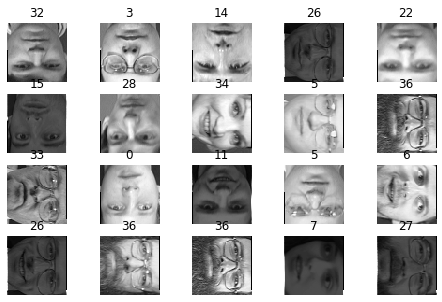

In [86]:
plot_faces(x_transformed, y_train[:20])

In [90]:
# Performing dimensionality reduction and passing through GMM

x_trans_pca = pca.transform(x_transformed.reshape(-1, 4096))
gm.score_samples(x_trans_pca)

array([-31048857.32721288, -28785244.13008472, -30903288.78152767,
       -87117680.32151146, -33763822.50992193, -75693243.18422584,
       -25133377.79180022, -37370090.01108618, -31312976.04728968,
       -40512306.71710093, -34986487.7651784 , -38597360.82775036,
       -95552792.76395534, -29575604.81127047, -31209562.43622105,
       -88856950.82481568, -48223007.98248579, -42451046.26077657,
       -92923096.75126128, -81559436.34622727])

### GMM scores them very poorly

In [91]:
gm.score_samples(x_train_pca[:20])

array([1172.73300455, 1030.73209726, 1030.7320966 , 1134.18747945,
       1135.00130225, 1134.47783239, 1136.69851921, 1155.85001147,
       1165.6439051 , 1187.06536432, 1165.32012454, 1141.63027182,
       1187.01546216, 1165.64390739, 1134.47783363, 1134.18747926,
       1194.21928734, 1187.06536421, 1185.56012933, 1186.07515778])

### In Comparison the original data had much higher scores